In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
#from numba import jit
import arviz as az

# NEED TO INSTALL LMFIT
import lmfit # conda install -c conda-forge lmfit
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import theano
import theano.tensor as t
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from datetime import date, timedelta, datetime
import matplotlib.dates as mdates
import math
import requests
import io
%matplotlib inline

from scipy.integrate import odeint
import lmfit

# Introduction

News of the novel coronavirus, now known as SARS-CoV-2, or more commonly, COVID-19, first broke in late December as Chinese health authorities confirmed that a mysterious pneumonia was sickening dozens of people in Wuhan. Soon thereafter, the virus permeated throughout mainland China at an astonishing speed as the death toll steadily grew as well, prompting a national lockdown. International authorities were placed on high alert as cases of the novel coronavirus began appearing worldwide, with the first confirmed case in the United States occurring on January 21st, 2020. COVID-19 proved to be extremely contagious, as cases in the United States increased exponentially. Schools and universities shut down in early March as the nation imposed lockdown orders.
 
COVID-19 is still at the forefront of the news. In these coming weeks, some nations are beginning to consider and implement plans to lift quarantine as social distancing measures seem to have had some effect on curbing the spread of the virus. What lies ahead, however, is still uncertain.
 
A large amount of research has already been conducted in order to better understand the future trajectory of the coronavirus. This research has largely been used to inform policy decisions moving forward and to better understand the epidemiological factors of the virus.


---

Our final project for CS109B aims to explore this existing research and to create our own models for COVID-19 by using some of the techniques that we have learned this semester in addition to some new ones that we have learned in our recent lectures with our resident epidemiologist, Dr. Mauricio Santillana.
 
Our primary model is an extended version of the well known epidemiological SIR model. The SIR model, which stands for Susceptible-Infected-Recovered, follows the trajectory of a virus through a homogeneously-mixed population given many parameters, such as rate of death, rate of infection, and so on.
 
We have created an SIR model that tracks the populations of the susceptible, exposed, infected, critical, and dead. Our essential goal was to estimate the parameters in the model, most specifically the R-nought parameter, which describes the rate of infectivity of a virus (how many people are infected from one person). We tried a number of techniques to do so. Below is a brief description of each model – their respective sections will go into more detail.
 
First, we tried a naïve fitting model, which estimated the parameters by finding what values produced a curve that minimized the MSE loss when compared to our true values. We used the daily death counts to fit this model.
 
Second, we wanted to find a way to fit our model to more than one curve as we had both daily death counts and daily confirmed cases. To do this, we fit models to both of the curves and minimized the residuals from both curves to come up with our final parameter estimates.
 
Third, we wanted to use a Bayesian MCMC Approximation to arrive at our parameter estimates. We used PyMC3 and priors informed by a brief literature review to model our data. While our results were not fantastic, the process was still educational.

Finally, we performed sensitivity analysis to determine a range of likely R-nought values from our data using the initial minimization approach.
 
After finding estimates for the R-nought, we modeled the R-nought against the mobility data to gain insight into how social distancing policies may have affected the infectivity rate of the virus and assess the effectiveness of such policies in slowing the virus’s spread.


# Body

## Data Preprocessing

In [5]:
# Fetching Live Data from CSSE 
url_confirm="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
url_death = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
s_confirm = requests.get(url_confirm).content
s_death = requests.get(url_death).content
confirmed_df = pd.read_csv(io.StringIO(s_confirm.decode('utf-8')))
deaths_df = pd.read_csv(io.StringIO(s_death.decode('utf-8')))

confirmed_df.rename(columns={"Admin2": "County"}, inplace=True)
deaths_df.rename(columns={"Admin2": "County"}, inplace=True)

Data from: https://www.ahd.com/state_statistics.html

Data are based on each hospital's most recent Medicare cost report

In [6]:
hospital_data = pd.read_csv("hospitaldata_bystate.csv")
hospital_data["Number of Beds"] = hospital_data["Number of Beds"].apply(lambda x: int(x.replace(",","")))

Data from https://www.kff.org/other/state-indicator/distribution-by-age/

Notes: 2018 Data

"Population and demographic data on are based on analysis of the Census Bureau’s American Community Survey (ACS) and may differ from other population estimates published yearly by the Census Bureau. U.S. and state population data displayed on this site are restricted to the civilian, non-institutionalized population for whom ACS collects and reports poverty information.

Population numbers are rounded to the nearest 100."

In [7]:
agegroups = pd.read_csv("agedata_bystate.csv")

In [8]:
# read the data
probabilities = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/probabilities.csv")

# create dicts for fast lookup
# 1. beds per state
beds_states_lookup = dict(zip(hospital_data["States"], hospital_data["Number of Beds"]))
# 2. agegroups per state
agegroup_lookup = dict(zip(agegroups['Location'], agegroups[['Children 0-18', 'Adults 19-25', 'Adults 26-34', 'Adults 35-54', 'Adults 55-64', '65+', 'Total']].values))

# store the probabilities collected
prob_I_to_C_1 = list(probabilities.prob_I_to_ICU_1.values)
prob_I_to_C_2 = list(probabilities.prob_I_to_ICU_2.values)
prob_C_to_Death_1 = list(probabilities.prob_ICU_to_Death_1.values)
prob_C_to_Death_2 = list(probabilities.prob_ICU_to_Death_2.values)

## Plotting Functions

In [9]:
plt.gcf().subplots_adjust(bottom=0.15)

def plotter(t, S, E, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None):
    if S_1 is not None and S_2 is not None:
      print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU: {S_2 * 100}")


    f, ax = plt.subplots(1,1,figsize=(20,4))
    if x_ticks is None:
        ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
        ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()


    ax.title.set_text('extended SEIR-Model')

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
    f = plt.figure(figsize=(20,4))
    # sp1
    ax1 = f.add_subplot(131)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

 
    ax1.title.set_text('R_0 over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
    # sp2
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(sigma*E[:i]) if sum(sigma*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
        ax2.xaxis.set_major_locator(mdates.YearLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax2.title.set_text('Fatality Rate (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    # sp3
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
        ax3.xaxis.set_major_locator(mdates.YearLocator())
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax3.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax3.title.set_text('Deaths per day')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
    
def SEIR_by_state(state_name, covid_data, state_params, outbreak_shift = 21, full_days = 500):
    '''
    firstdate = first date of our data - outbreakshift
    '''
    first_date = datetime.strptime(covid_data.columns[0], "%m/%d/%y") - timedelta(days = outbreak_shift)
    x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
    print("Prediction for " + state_name)
    fit_model = Model(full_days, agegroup_lookup[state_name], beds_states_lookup[state_name], **state_params)
    plotter(*fit_model, x_ticks=x_ticks)
    
    plt.title("Predictions for Coronavirus Over Time")
    plt.xlabel("Days since Outbreak")
    plt.ylabel("Number of People")
    plt.plot(fit_model[3], label = "Cases")
    plt.plot(fit_model[6], label = "Deaths")
    plt.legend()
    plt.show()

<Figure size 432x288 with 0 Axes>

## Create an SIR Model


*SIR Modeling: Rationale for our choice of modeling (why use SEIRCD?)*

An SIR model is a common, simple model used to estimate the epidemiological behavior. It relies on a number of differential equations that describes the spread of a disease in a closed, homogeneously-mixed system. In its most basic form, there are typically three compartments - susceptible, infected, and recovered. The differential equations model how individuals move from compartment to compartment. The infectious rate, $\beta$, controls the rate of spread, which represents the probability of transmitting disease between a susceptible and infected individual. The recovery rate, $\gamma$, is determined by the average duration of the infection. R-nought, commonly referred to as the “basic reproduction number”, indicates how contagious a disease is and is calculated as $\beta / \gamma$. We focused on this parameter to understand how social distancing measures might be related to the R-nought and explored it through means. In our final SIR model, we added 3 more compartments, exposed, critical, and dead, to better reflect what COVID-19 might look like in reality. The models below are ways we tried to estimate the parameters of our SIR model.


In [10]:
# Rates are derived from literature review of COVID rates
# Number of days from infected to critical: 12 (→rate: 1/12)
# Number of days from critical to dead: 7.5 (→rate: 1/7.5)
# Number of days from critical to recovered: 6.5 (→rate: 1/6.5)
days_to_critical = 12.0
days_C_to_D = 7.5
days_C_to_R = 6.5

def deriv(y, t, beta, gamma, sigma, N, p_I_to_C, p_C_to_D, Beds):
    '''
    Models the derivatives of the SEIR Model directly from epidemiological model
    '''
    S, E, I, C, R, D = y

    dSdt = -beta(t) * I * S / N
    dEdt = beta(t) * I * S / N - sigma * E
    dIdt = sigma * E - 1/days_to_critical * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    dCdt = 1/days_to_critical * p_I_to_C * I - 1/days_C_to_D * p_C_to_D * min(Beds(t), C) - max(0, C-Beds(t)) - (1 - p_C_to_D) * 1/days_C_to_R * min(Beds(t), C)
    dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/days_C_to_R * min(Beds(t), C)
    dDdt = 1/days_C_to_D * p_C_to_D * min(Beds(t), C) + max(0, C-Beds(t))
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

In [11]:
gamma = 1.0/9.0
sigma = 1.0/3.0

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    '''
    Models the R_0 as a variable that changes over time
    t = time
    R_0_start = R_0 at the start of the model
    R_0_end = R_0 at the end of specified prediction time
    k = expresses the speed at which R_0 evolves
    x0 = inflection point for the change of R_0
    '''
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end


def Model(days, agegroups, beds_0, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
    '''
    Function: takes the inputs and outputs the SEIRCD numbers for the population modeled by
    the derivative functions that we set before.
    
    ~ Input Variables ~ 
    
    days = number of days in our data
    agegroups = demographic breakdown of population in each agegroup in the region
    beds_0 = number of hospital beds in the state 
    R_0_start = R_0 at the start of our model
    k = how quickly R_0_start transitions to R_0_end, the speed of R_0 evolution 
    x0 = inflection point in the R_0
    R_0_end = R_0 at the end of our model
    prob_I_to_C = probability of infected patients becoming critical
    prob_C_to_D = probability of critical patients dying
    s = scale at which beds become available over time
    
    ~ Output Variables ~
    
    t = time
    S = population that is susceptible
    E = population that is exposed
    I = population that is infected
    C = population that is critical
    R = population that is recovered (removed from pool of susceptible)
    D = population that has died from the disease
    R_0_over_time = returns the R_0 over time in the model
    Beds = returns the number of beds available at each time step
    prob_I_to_C = probability of infected patients becoming critical
    prob_C_to_D = probability of critical patients dying
    '''
    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma

    if(isinstance(agegroups,np.ndarray)):
        N = sum(agegroups)
    else:
        N = agegroups
    
    def Beds(t):
        return beds_0*.1 + s*.1*beds_0*t  # 0.003

    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days, days)
    ret = odeint(deriv, y0, t, args=(beta, gamma, sigma, N, prob_I_to_C, prob_C_to_D, Beds))
    S, E, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]
    
    return t, S, E, I, C, R, D, R_0_over_time, Beds, prob_I_to_C, prob_C_to_D

## Fit SEIR Model to our Data

### Preprocessing

In [12]:
# Deaths numbers starts at column index 12
deaths_df.iloc[:,[12]].head()

,1/22/20
0,0
1,0
2,0
3,0
4,0


In [13]:
deaths_by_state = pd.concat([deaths_df["Province_State"],deaths_df.iloc[:,12::]], axis=1)
deaths_by_state = deaths_by_state.groupby("Province_State").sum()

In [14]:
# Confirmed numbers
confirmed_by_state = pd.concat([confirmed_df["Province_State"],confirmed_df.iloc[:,11::]], axis=1)
confirmed_by_state = confirmed_by_state.groupby("Province_State").sum()

In [15]:
confirmed_by_state.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20
Province_State,,,,,,,,,,,,,,,,,,,,,
Alabama,0,0,0,0,0,0,0,0,0,0,...,7088,7294,7611,7888,8112,8437,8691,9046,9385,9668
Alaska,0,0,0,0,0,0,0,0,0,0,...,355,364,365,368,370,371,372,374,377,378
American Samoa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arizona,0,0,0,0,1,1,1,1,1,1,...,7655,7969,8364,8640,8924,9305,9707,9945,10526,10960
Arkansas,0,0,0,0,0,0,0,0,0,0,...,3281,3337,3372,3437,3491,3525,3611,3703,3747,3747


### Specify Data for Modeling

In [16]:
def data_by_state(state_, outbreak_shift = 21): 
    '''
    ~ Modify for each state that we look at ~
    data = Deaths by state 
    data2 = Confirmed cases by state
    beds_in_-- = the number of beds in a specific state, modify lookup accordingly
    agegroups = the demographic breakdown in a specific state, modify lookup accordingly
    outbreakshift = number of days that we shift the outbreak back by to account for potential data inaccuracy
    params_init_min_max = initialize the epidemiological parameters for the SEIR model
    '''
    data = deaths_by_state[deaths_by_state.index == state_].values
    data = data[0]

    data2 = confirmed_by_state[confirmed_by_state.index == state_].values
    data2 = data2[0]

    agegroups_in_state = agegroup_lookup[state_]
    beds_in_state = beds_states_lookup[state_] * 0.1

    # form: {parameter: (initial guess, minimum value, max value)}
    '''
    can vary initial parameters:
    R_0_start, R_0_end, k
    '''
    params_init_min_max = {"R_0_start": (3.0, 2.0, 5.0), "k": (0.3, 0.01, 2), "x0": (90, 0, 120), "R_0_end": (0.9, 0.3, 3.5),
                           "prob_I_to_C": (0.05, 0.01, 0.1), "prob_C_to_D": (0.5, 0.05, 0.8),
                           "s": (0.003, 0.001, 0.01)}

    # Process Data for modeling
    days = outbreak_shift + len(data)
    if outbreak_shift >= 0:
        y_data = np.concatenate((np.zeros(outbreak_shift), data))
    else:
        y_data = y_data[-outbreak_shift:]

    x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array
    
    return data, data2, agegroups_in_state, beds_in_state, params_init_min_max, days, y_data, x_data


## Simple Fitting

In [17]:
def fitter(x, days, agegroups_in_state, beds_in_state, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
    ret = Model(days, agegroups_in_state, beds_in_state, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s)
    return ret[6][x]

In [18]:
def model_fit(state_data):
    mod= lmfit.Model(fitter)
#   iterate through initial parameters for each state
    for kwarg, (init, mini, maxi) in state_data[4].items():
        mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)
    mod.set_param_hint("days", value = state_data[5], vary = False)
    mod.set_param_hint("agegroups_in_state", value = sum(state_data[2]), vary = False)
    mod.set_param_hint("beds_in_state", value = state_data[3], vary = False)
    
    params = mod.make_params()
    
    fit_method = "least_squares"
    result = mod.fit(state_data[6], params, method=fit_method, x=state_data[7])
    return result

In [20]:
ny_data = data_by_state("New York")
ca_data = data_by_state("California")
ga_data = data_by_state("Georgia")

In [21]:
ny_model = model_fit(ny_data)
ca_model = model_fit(ca_data)
ga_model = model_fit(ga_data)

{'days': 130,
 'agegroups_in_state': 38033900.0,
 'beds_in_state': 5728.8,
 'R_0_start': 3.2430755359398873,
 'k': 0.5785006992815375,
 'x0': 91.55538326523542,
 'R_0_end': 0.5190390471825777,
 'prob_I_to_C': 0.05143384749307131,
 'prob_C_to_D': 0.22894490650712976,
 's': 0.0010000027500527235}

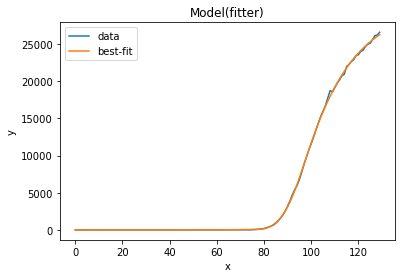

In [22]:
# New York
ny_model.plot_fit(datafmt="-")
ny_model.best_values

{'days': 130,
 'agegroups_in_state': 77491800.0,
 'beds_in_state': 7462.400000000001,
 'R_0_start': 3.1740330606429565,
 'k': 0.7949963902104175,
 'x0': 90.77907277247127,
 'R_0_end': 1.0198090484011553,
 'prob_I_to_C': 0.015759475396592816,
 'prob_C_to_D': 0.2975295487027965,
 's': 0.008442301044621292}

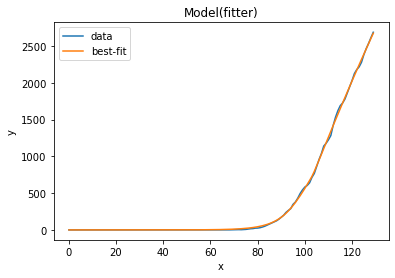

In [23]:
# California
ca_model.plot_fit(datafmt="-")
ca_model.best_values

{'days': 130,
 'agegroups_in_state': 20425700.0,
 'beds_in_state': 2252.1,
 'R_0_start': 2.8705138048342222,
 'k': 0.2678479183632146,
 'x0': 83.77993420405636,
 'R_0_end': 1.0040405036582625,
 'prob_I_to_C': 0.040980945526357525,
 'prob_C_to_D': 0.24731128434912417,
 's': 0.0025783851095611096}

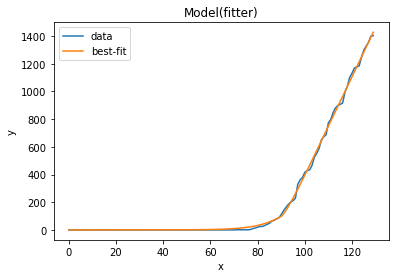

In [24]:
# Georgia
ga_model.plot_fit(datafmt="-")
ga_model.best_values

## Minimizing Residuals from Multiple Fits

In [25]:
from functools import partial

def var(data,std):
    '''
    Add error terms to our data
    '''
    error = np.random.normal(0, scale = std)
    new_data = data + error
    new_data[new_data<0] = 0 
    return new_data

def residual(p, days, agegroups_in_state, beds_in_state, x, y_data, y_data_2, error = False):
    '''
    Residual fitting model
    '''
    # Add error to agegroup and beds data
    if(error == True):
        ret = Model(days, agegroups_in_state, beds_in_state, **p)
    else:
        sd_age = max(agegroups_in_state)*.05
        sd_beds = beds_in_NY*.05
        age_groups_error = var(agegroups_in_state, sd_age)
        beds_in_state_error = var(np.array([beds_in_state]),sd_beds)
        ret = Model(days, age_groups_error, beds_in_state_error, **p)
    
    # Calculate Residuals
    resid1 = y_data - ret[6][x]
    resid2 = y_data_2 - ret[3][x]
    
    # Return sum of residuals
    return abs(resid1) + abs(resid2)

In [26]:
## Track parameter value 

def param_estimates_state(s_data, outbreak_shift = 21, num_trials = 1, error = True):
    '''
    Estimates the parameters for each state
    
    ~Inputs~
    s_data contains an array of values:
        0: data - array of daily deaths 
        1: data2 - array of daily confirmed cases
        2: agegroups_in_state - array of agegroups in the corresponding state
        3: beds_in_state - number of beds in the corresponding state
        4: params_init_min_max - the initial parameters for the model
        5: days - the number of days we have data available for 
        6: y_data - shifted array of daily deaths
        7: x_data - array [0,1,...,maxdays]
    
    outbreak_shift: number of days to shift back outbreak by
    num_trials: number of trials wanted for sensitivity analysis
    error: whether you want to have error added to the data for each trial
    
    ~Outputs~
    Array of parameter estimates
    '''
    param_estimate = []

    # Shifts data according to when the first outbreak is believed to happen
    if outbreak_shift >= 0:
        y_data_2 = np.concatenate((np.zeros(outbreak_shift), s_data[1]))
    else:
        y_data_2 = y_data_2[-outbreak_shift:]

    # Create parameters object and populate with initial parameters
    pars = lmfit.Parameters()
    for kwarg, (init, mini, maxi) in s_data[4].items():
        pars.add(str(kwarg), value=init, min=mini, max=maxi, vary=True)

    # Fit residual data
    for i in range(num_trials):
        # Add error terms to the y_data (deaths and confirmed cases)
        y_data_error = var(s_data[6], s_data[6]*0.05)
        y_data_2_error = var(y_data_2, y_data_2*0.05)
        
        # Partial our function for better usage in lmfit
        function = partial(residual, days = s_data[5], agegroups_in_state = s_data[2], beds_in_state = s_data[3],
                           x = s_data[7], y_data= y_data_error, y_data_2= y_data_2_error, error = error)
        
        # Minimize residuals from both curves
        mini = lmfit.Minimizer(function, pars)
        result = mini.minimize()
        
        # Append parameters to list
        temp = []
        for i,j in result.params.items():
            values = j.value
            temp.append(values)
        param_estimate.append(temp)
        
    return param_estimate, result

In [ ]:
# ny_params, ny_result = param_estimates_state(ny_data, num_trials = 1)
# ca_params, ca_result = param_estimates_state(ca_data, num_trials = 1)
# ga_params, ga_result = param_estimates_state(ga_data, num_trials = 1)

In [ ]:
# Read from CSVs
# Average into one column
# Transform into dict

In [ ]:
SEIR_by_state("New York", deaths_by_state, ny_params_dict)

## Bayesian Model Fitting

In [23]:
def SIR(y, t, p):
#     S, E, I, C, R, D = y
#     p_I_to_C, p_C_to_D, k, x0, R_0_start, R_0_end, gamma, sigma = p
#        0         1      2  3       4          5      6     7

    days_to_critical = 12.0
    days_C_to_D = 7.5
    days_C_to_R = 6.5
    N = 1.0
    
    beta = ((p[4]-p[5]) / (1 + np.exp(-p[2]*(-t+p[3]))) + p[5]) * p[6]
    dSdt = -beta * y[2] * y[0] / N
    dEdt = beta * y[2] * y[0] / N - p[7] * y[1]
    dIdt = p[7] * y[1] - 1/days_to_critical * p[0] * y[2] - p[6] * (1 - p[0]) * y[2]
    dCdt = 1/days_to_critical * p[0] * y[2] - 1/days_C_to_D * p[1] * y[3] - (1 - p[1]) * 1/days_C_to_R * y[3]
    dRdt = p[6] * (1 - p[0]) * y[2] + (1 - p[1]) * 1/days_C_to_R * y[3]
    dDdt = 1/days_C_to_D * p[1] * y[3]
    
    return [dSdt, dEdt, dIdt, dCdt, dRdt, dDdt]

R_nought = beta / gamma

In [1]:
# sir_model = DifferentialEquation(
#     func=SIR,
#     times=np.array(x_data),
#     n_states=6, n_theta=8,
#     t0=0
# )

# with pm.Model() as model:
#     sd = pm.HalfCauchy('sigma', 1)
    
#     p_I_to_C = pm.Beta("p_I_to_C", 5, 1)
#     p_C_to_D = pm.Beta("p_C_to_D", 5, 1)
#     # p_I_to_C = pm.Uniform("p_I_to_C", 0, 0.2)
#     # p_C_to_D = pm.Uniform("p_C_to_D", 0, 0.2)
    
#     # k = pm.Bound(pm.Lognormal, upper=7)("k", mu=0, sd=1) # add upper bound of 5 or so
#     k = 4
#     # x_0 = pm.Bound(pm.Lognormal, upper=len(x_data))("x_0", mu=pm.math.log(90), sd=1)
#     x_0 = 90
#     R_0_start = pm.Bound(pm.Normal, lower=1, upper=5)("R_0_s", mu=2, sd=2)
#     R_0_end = pm.Bound(pm.Normal, lower=0, upper=5)("R_0_e", mu=1, sd=2)
#     # TODO: introduce bounds for k
#     # TODO: Try moving beta here and make it deterministic using logit
#     # TODO: Scale these, ie 1 / X = what we have
    
#     # best estimates from papers
#     gamma = 1.0/9.0 
#     sigma = 1.0/3.0
    
#     N = sum(agegroup_lookup["US"])
    
#     y0 = [0.99, 0.01, 0.0, 0.0, 0.0, 0.0]
#     sir_curves = sir_model(y0=y0, theta=[p_I_to_C, p_C_to_D, k, x_0, R_0_start, R_0_end, gamma, sigma])
    
#     Y = pm.Normal('Y', mu=sir_curves[:,5], sd=sd, observed=y_data/N)
#     trace = pm.sample(1000, tune=500)  

Note: Above Code is depreciated because it took to long to run. 14+ hours for one chain to be sampled.

## Try using a smaller model

Alpha: is the conversion parameter for exposed individuals that transformed into infected ones

Beta: is the conversion parameter due to interaction between a susceptible individual with an infected one

Gamma: is the conversion rate parameter for susceptible individuals that interact with exposed individuals and then become exposed

Zeta: is the conversion parameter related to the recovery rate

Delta: is the mortality rate for the disease

R_0: beta / zeta

In [20]:
def SEIRD(y, t, p):
    # S, E, I, R, D = y
    # alpha, beta, gamma, zeta, delta = p
    S_prime = - p[1] * y[0] * y[2] - p[2] * y[1] * y[0]
    E_prime = p[1] * y[0] * y[2] - p[0] * y[1] + p[2] * y[1] * y[0]
    I_prime = p[0] * y[1] - p[3] * y[2] - p[4] * y[2]
    R_prime = p[3] * y[2]
    D_prime = p[4] * y[2]
    return [S_prime, E_prime, I_prime, R_prime, D_prime]

In [26]:
seir_model = DifferentialEquation(
    func=SEIRD,
    times=np.array(x_data),
    n_states=5, n_theta=5,
    t0=0
)

with pm.Model() as model2:
    sd = pm.HalfCauchy('sigma', 1)
    
    # alpha = pm.Uniform("alpha", 0, 0.1)
    alpha = 1 / 3
    beta = pm.Uniform("beta", 0, 0.5)
    gamma = pm.Uniform("gamma", 0, 0.5)
    zeta = 1 / 14
    # zeta = pm.Uniform("zeta", 0, 0.1)
    delta = pm.Uniform("delta", 0, 0.1)
    
    # From before: 
    # also try alpha=1/4, zeta = 1/14, gamma=1/9
    # gamma = 1 / D (D is days with infection)
    # alpha = 1 / I (I is incubation days)
    
    N = sum(agegroup_lookup["US"])
    
    y0 = [0.99, 0.01, 0.0, 0.0, 0.0]
    sir_curves = seir_model(y0=y0, theta=[alpha, beta, gamma, zeta, delta])
    
    Y = pm.Normal('Y', mu=sir_curves[:,4], sd=sd, observed=y_data / N)
    trace = pm.sample(200, tune=100)  

//anaconda3/envs/cs109b/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
//anaconda3/envs/cs109b/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
//anaconda3/envs/cs109b/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file

In [39]:
with model2:
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)
    data = az.from_pymc3(trace=trace, prior = prior, posterior_predictive = posterior_predictive)

100%|██████████| 800/800 [02:34<00:00,  5.18it/s]


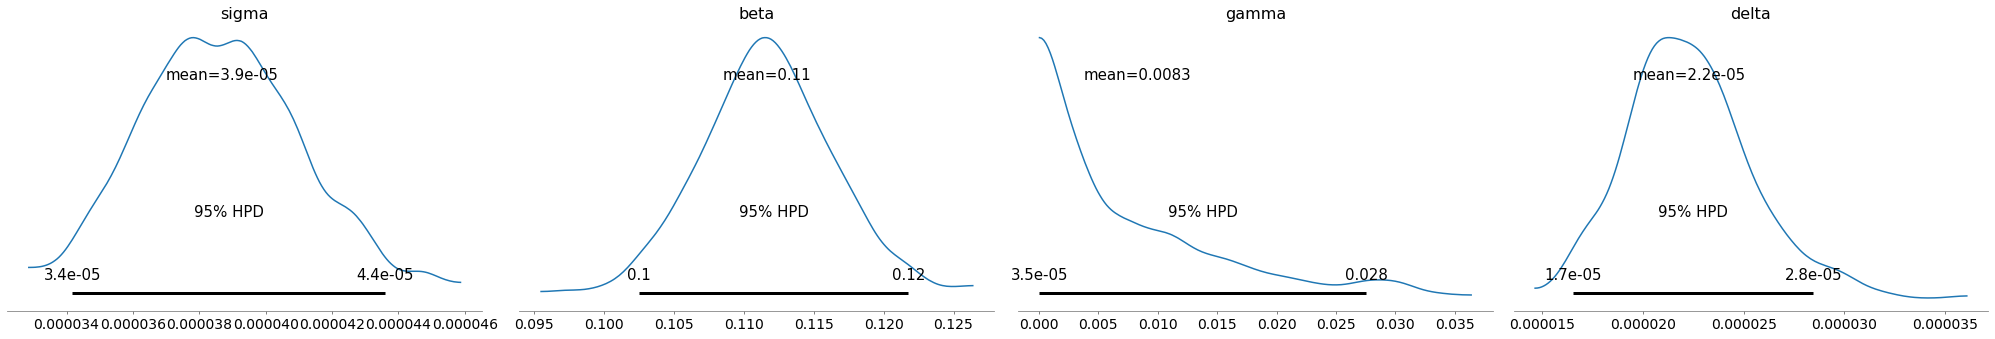

In [40]:
az.plot_posterior(data,round_to=2, credible_interval=0.95);

//anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
//anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
//anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
//anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied val

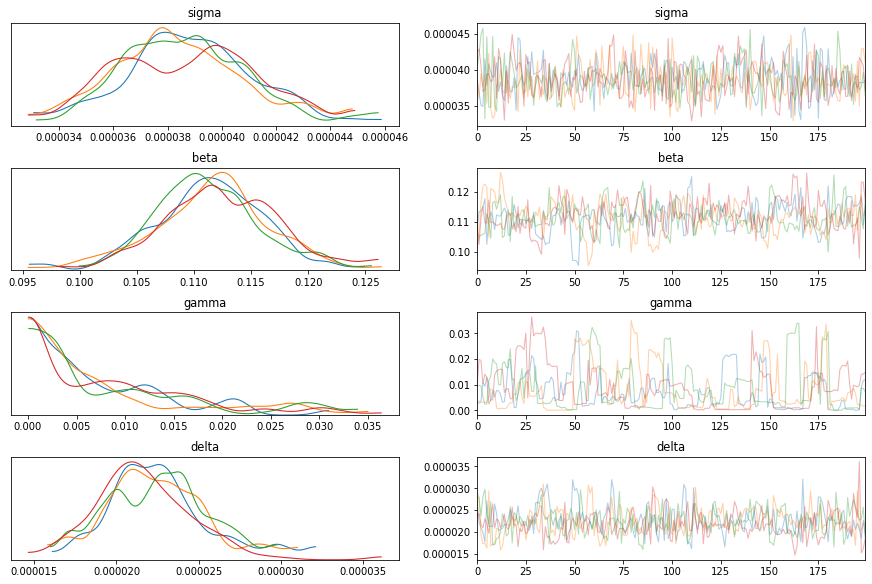

In [27]:
pm.traceplot(trace);

From this, we estimate an $R_0$ between 1.4 and 1.68 using the 95% credible interval for $\beta$ and the value for $\zeta$.

# Can we make this faster?

The above implementation seems really slow. Try implementing https://www.kaggle.com/volpatto/covid-19-study-with-epidemiology-models as a way to solve the differential equations.

In [48]:
import requests
import io

In [49]:
# Fetching Live Data from CSSE 
url_confirm="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
url_death = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
s_confirm = requests.get(url_confirm).content
s_death = requests.get(url_death).content
confirmed_df = pd.read_csv(io.StringIO(s_confirm.decode('utf-8')))
deaths_df = pd.read_csv(io.StringIO(s_death.decode('utf-8')))
confirmed_df.rename(columns={"Admin2": "County"}, inplace=True)
deaths_df.rename(columns={"Admin2": "County"}, inplace=True)

In [115]:
deaths_by_state = pd.concat([deaths_df["Province_State"],deaths_df.iloc[:,12::]], axis=1)
deaths_by_state = deaths_by_state.groupby("Province_State").sum()
# Confirmed numbers
confirmed_by_state = pd.concat([confirmed_df["Province_State"],confirmed_df.iloc[:,11::]], axis=1)
confirmed_by_state = confirmed_by_state.groupby("Province_State").sum()

In [116]:
deaths_updated = deaths_by_state.values.sum(axis=0)
confirmed_updated = confirmed_by_state.values.sum(axis=0)

In [117]:
outbreak_shift = 20
days = outbreak_shift + len(deaths_updated)
if outbreak_shift >= 0:
    deaths_updated = np.concatenate((np.zeros(outbreak_shift), deaths_updated))
    confirmed_updated = np.concatenate((np.zeros(outbreak_shift), confirmed_updated))
else:
    print("NOT IMPLEMENTED")

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

In [120]:
@jit(nopython=True)
def SIR_model(y, t, p_I_to_C, p_C_to_D, k, x0, R_0_start, R_0_end, gamma, sigma):
    days_to_critical = 12.0
    days_C_to_D = 7.5
    days_C_to_R = 6.5
    N = 1.0
    
    beta = ((R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end) * gamma
    
    S, E, I, C, R, D = y

    dSdt = -beta * I * S / N
    dEdt = beta * I * S / N - sigma * E
    dIdt = sigma * E - 1/days_to_critical * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    dCdt = 1/days_to_critical * p_I_to_C * I - 1/days_C_to_D * p_C_to_D * C - (1 - p_C_to_D) * 1/days_C_to_R * C
    dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/days_C_to_R * C
    dDdt = 1/days_C_to_D * p_C_to_D * C
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

In [121]:
def seir_ode_solver(y0, t, p_I_to_C, p_C_to_D, gamma, sigma, k=4, x0=100, R_0_start=3, R_0_end=1):
    solution_ODE = odeint(SIR_model, y0, t, args=(p_I_to_C, p_C_to_D, k, x0, R_0_start, R_0_end, gamma, sigma))
    
    return solution_ODE

In [122]:
@theano.compile.ops.as_op(itypes=[t.dvector, t.dvector, t.dvector, t.dscalar, t.dscalar, t.dscalar, t.dscalar, t.dscalar, t.dscalar], otypes=[t.dvector, t.dvector])
def seir_ode_solver_wrapper(x_data, f_observations, initial_conditions, p_I_to_C, p_C_to_D, R_0_start, R_0_end, k, x0, gamma=1/9, sigma=1/3):
    
    y_model = seir_ode_solver(initial_conditions, x_data, p_I_to_C, p_C_to_D, gamma, sigma, k, x0, R_0_start, R_0_end)
    simulated_ode_solution = y_model.T
    _, _, simulated_infections, _, _, simulated_deaths = simulated_ode_solution

    return simulated_infections, simulated_deaths

In [127]:
with pm.Model() as model_mcmc:
    # Prior distributions for the model's parameters
    sd = pm.HalfCauchy('sigma', 1, shape=2)
    #p_I_to_C = pm.Beta("p_I_to_C", 2, 10)
    #p_C_to_D = pm.Beta("p_C_to_D", 2, 5)
    p_I_to_C = pm.Uniform("p_I_to_C", 0, 0.1)
    p_C_to_D = pm.Uniform("p_C_to_D", 0.05, 0.5)
    
    k = pm.Bound(pm.Lognormal, upper=7)("k", mu=0, sd=1) # add upper bound of 5 or so
    x_0 = pm.Bound(pm.Lognormal, upper=len(x_data))("x_0", mu=pm.math.log(90), sd=1)
    R_0_start = pm.Bound(pm.Normal, lower=1, upper=7)("R_0_s", mu=3, sd=2)
    R_0_end = pm.Bound(pm.Normal, lower=0, upper=2)("R_0_e", mu=1, sd=2)
    
    # best estimates from papers
    # gamma = 1.0/9.0
    # sigma = 1.0/3.0
    
    N = sum(agegroup_lookup["US"])

    # Defining the deterministic formulation of the problem
    solution = seir_ode_solver_wrapper(
        theano.shared(x_data.astype("float64")), 
        theano.shared(deaths_updated / N), 
        theano.shared(np.array([0.99, 0.01, 0.0, 0.0, 0.0, 0.0])),
        p_I_to_C, p_C_to_D, R_0_start, R_0_end, k, x_0
        )
    
    fitting_infections = pm.Deterministic('infec_model', solution[0])
    fitting_deaths = pm.Deterministic('death_model', solution[1])

    likelihood_model = pm.Normal('likelihood_model_1', mu=fitting_infections, sigma=sd[0], observed=confirmed_updated / N)
    likelihood_model_2 = pm.Normal('likelihood_model_2', mu=fitting_deaths, sigma=sd[1], observed=deaths_updated / N)
    
    # The Monte Carlo procedure driver
    step = pm.step_methods.Metropolis()
    seir_trace = pm.sample(int(5e5), tune=int(2e5), chains=4, cores=4, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [R_0_e]
>Metropolis: [R_0_s]
>Metropolis: [x_0]
>Metropolis: [k]
>Metropolis: [p_C_to_D]
>Metropolis: [p_I_to_C]
>Metropolis: [sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 2800000/2800000 [3:02:49<00:00, 255.25draws/s]  
The number of effective samples is smaller than 10% for some parameters.


//anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
//anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
//anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
//anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied val

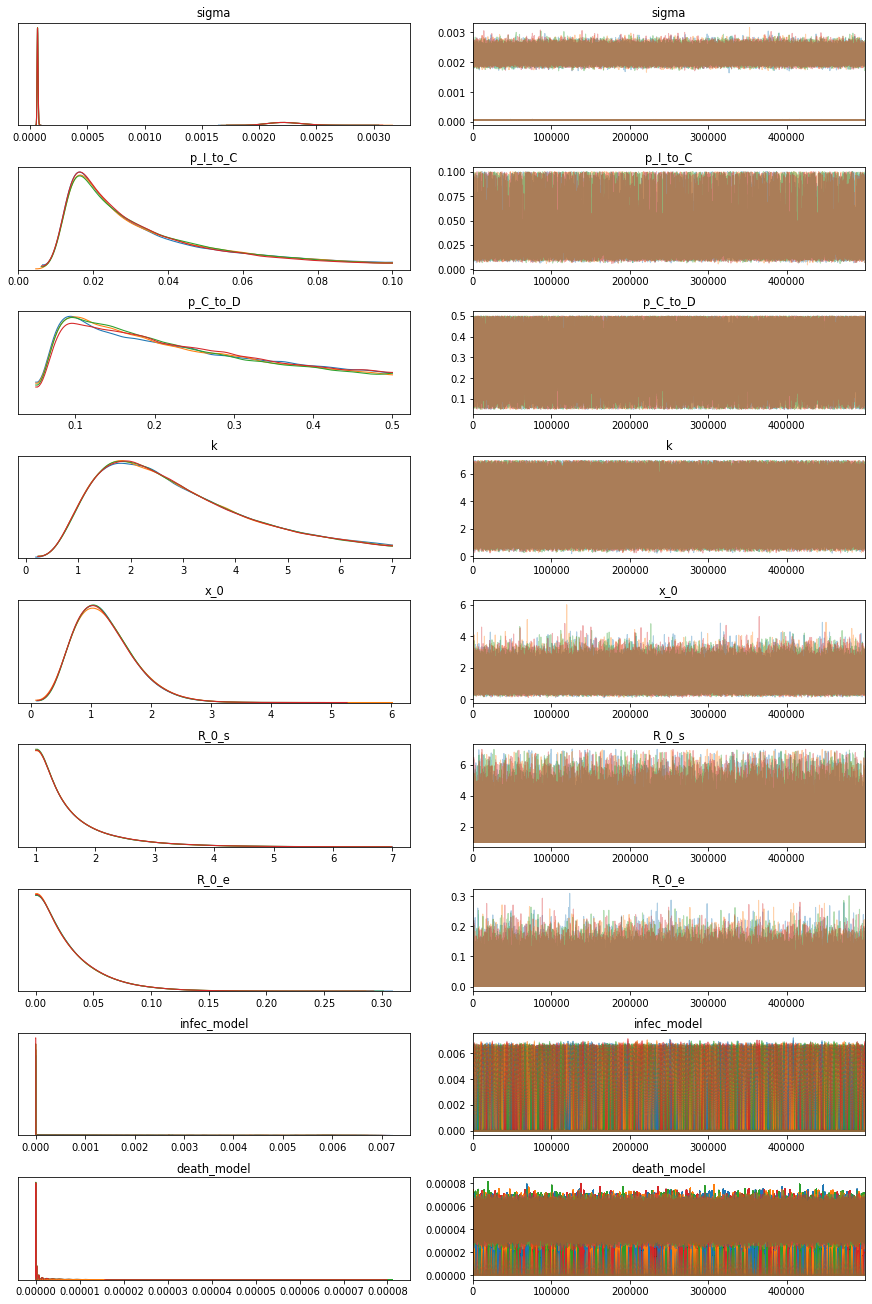

In [128]:
pm.traceplot(seir_trace);

# R-nought Modeling

## Examine the parameter estimates

In [37]:
state_name = "Michigan"
state_df = pd.read_csv(f"../Parameter_Estimates/{state_name}_final.csv")
quantiles = np.quantile(state_df.values, [0.025, 0.5, 0.975], 0)
print(f"Quantiles for {state_name}")
print(" Parameter\t 2.5%\t 50%\t 97.5%")
for i, col in enumerate(state_df.columns):
    if i in [1,2,6]:
        print(f"{col}:\t\t{quantiles[0, i]: 0.3f}\t{quantiles[1, i]: 0.3f}\t{quantiles[2, i]: 0.3f}")
    else:
        print(f"{col}:\t{quantiles[0, i]: 0.3f}\t{quantiles[1, i]: 0.3f}\t{quantiles[2, i]: 0.3f}")

Quantiles for Alabama
 Parameter	 2.5%	 50%	 97.5%
R_0_start:	 2.153	 2.962	 3.001
k:		 0.238	 0.300	 0.353
x0:		 75.798	 90.021	 102.143
R_0_end:	 0.708	 0.902	 1.782
prob_I_to_C:	 0.046	 0.050	 0.057
prob_C_to_D:	 0.438	 0.500	 0.593
s:		 0.002	 0.003	 0.005


In [38]:
state_name = "California"
state_df = pd.read_csv(f"../Parameter_Estimates/{state_name}_final.csv")
quantiles = np.quantile(state_df.values, [0.025, 0.5, 0.975], 0)
print(f"Quantiles for {state_name}")
print(" Parameter\t 2.5%\t 50%\t 97.5%")
for i, col in enumerate(state_df.columns):
    if i in [1,2,6]:
        print(f"{col}:\t\t{quantiles[0, i]: 0.3f}\t{quantiles[1, i]: 0.3f}\t{quantiles[2, i]: 0.3f}")
    else:
        print(f"{col}:\t{quantiles[0, i]: 0.3f}\t{quantiles[1, i]: 0.3f}\t{quantiles[2, i]: 0.3f}")

Quantiles for California
 Parameter	 2.5%	 50%	 97.5%
R_0_start:	 2.548	 2.765	 3.000
k:		 0.130	 0.300	 0.409
x0:		 84.975	 90.476	 99.810
R_0_end:	 0.645	 0.928	 1.508
prob_I_to_C:	 0.042	 0.050	 0.059
prob_C_to_D:	 0.402	 0.501	 0.608
s:		 0.002	 0.003	 0.005


In [39]:
state_name = "Georgia"
state_df = pd.read_csv(f"../Parameter_Estimates/{state_name}_final.csv")
quantiles = np.quantile(state_df.values, [0.025, 0.5, 0.975], 0)
print(f"Quantiles for {state_name}")
print(" Parameter\t 2.5%\t 50%\t 97.5%")
for i, col in enumerate(state_df.columns):
    if i in [1,2,6]:
        print(f"{col}:\t\t{quantiles[0, i]: 0.3f}\t{quantiles[1, i]: 0.3f}\t{quantiles[2, i]: 0.3f}")
    else:
        print(f"{col}:\t{quantiles[0, i]: 0.3f}\t{quantiles[1, i]: 0.3f}\t{quantiles[2, i]: 0.3f}")

Quantiles for Georgia
 Parameter	 2.5%	 50%	 97.5%
R_0_start:	 2.383	 2.693	 3.000
k:		 0.263	 0.300	 0.351
x0:		 81.914	 90.210	 103.766
R_0_end:	 0.413	 0.916	 1.695
prob_I_to_C:	 0.042	 0.050	 0.055
prob_C_to_D:	 0.392	 0.500	 0.585
s:		 0.002	 0.003	 0.008


In [40]:
state_name = "Michigan"
state_df = pd.read_csv(f"../Parameter_Estimates/{state_name}_final.csv")
quantiles = np.quantile(state_df.values, [0.025, 0.5, 0.975], 0)
print(f"Quantiles for {state_name}")
print(" Parameter\t 2.5%\t 50%\t 97.5%")
for i, col in enumerate(state_df.columns):
    if i in [1,2,6]:
        print(f"{col}:\t\t{quantiles[0, i]: 0.3f}\t{quantiles[1, i]: 0.3f}\t{quantiles[2, i]: 0.3f}")
    else:
        print(f"{col}:\t{quantiles[0, i]: 0.3f}\t{quantiles[1, i]: 0.3f}\t{quantiles[2, i]: 0.3f}")

Quantiles for Michigan
 Parameter	 2.5%	 50%	 97.5%
R_0_start:	 2.528	 2.776	 3.000
k:		 0.255	 0.300	 0.360
x0:		 85.362	 90.426	 105.392
R_0_end:	 0.656	 0.948	 1.402
prob_I_to_C:	 0.045	 0.050	 0.054
prob_C_to_D:	 0.477	 0.501	 0.572
s:		 0.002	 0.003	 0.006


In [42]:
state_name = "New_York"
state_df = pd.read_csv(f"../Parameter_Estimates/{state_name}_final.csv")
quantiles = np.quantile(state_df.values, [0.025, 0.5, 0.975], 0)
print(f"Quantiles for {state_name}")
print(" Parameter\t 2.5%\t 50%\t 97.5%")
for i, col in enumerate(state_df.columns):
    if i in [1,2,6]:
        print(f"{col}:\t\t{quantiles[0, i]: 0.3f}\t{quantiles[1, i]: 0.3f}\t{quantiles[2, i]: 0.3f}")
    else:
        print(f"{col}:\t{quantiles[0, i]: 0.3f}\t{quantiles[1, i]: 0.3f}\t{quantiles[2, i]: 0.3f}")

Quantiles for New_York
 Parameter	 2.5%	 50%	 97.5%
R_0_start:	 2.812	 3.000	 3.095
k:		 0.246	 0.300	 0.311
x0:		 83.662	 90.000	 99.504
R_0_end:	 0.898	 0.901	 1.949
prob_I_to_C:	 0.047	 0.050	 0.052
prob_C_to_D:	 0.361	 0.500	 0.547
s:		 0.002	 0.003	 0.004


## Read in mobility data

Note: all our estimates are from Jan 1st, whereas the mobility data starts January 13. We also have 5 extra days of predictions.

In [55]:
def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    '''
    Models the R_0 as a variable that changes over time
    t = time
    R_0_start = R_0 at the start of the model
    R_0_end = R_0 at the end of specified prediction time
    k = expresses the speed at which R_0 evolves
    x0 = inflection point for the change of R_0
    '''
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

In [43]:
apple_mob = pd.read_csv("../applemobilitytrends-2020-05-03.csv")

In [59]:
avg_mob = np.mean(apple_mob.loc[apple_mob["region"] == "Atlanta"].values[:,4:], axis=0)

In [60]:
time = np.arange(0, len(avg_mob), 1)

In [68]:
r0s = np.apply_along_axis(lambda t: logistic_R_0(t, R_0_start, k, x0, R_0_end), 0, time)